This is version 2 where I used the GradientBoostingRegressor (gbr) with default parameters  and I added a few new features in addition to Day, Month and Season (from the previous version) such as the tax per square foot etc. I removed some of the features with large number of missing values and changed the dtypes to keep the properties frame under 0.7GB and the number of features at 64. On its own this gave LB 0.06445 but when combined (simply averaged) with some of the other public kernels that have similar score on their own the result was 0.06426 (top 5%).  Suprisingly both lgbm and xgb gave worse score with the extra features.  The rest of the notebook compares the feature importances between gbr  and lgbm and xgb and looks at the impact of each feature. The test set score seems to converge at about 30 features but keeping all 64 gave a better LB score.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
import lightgbm as lgb
import xgboost as xgb
import datetime as dt
import gc

print('loading files...')
prop = pd.read_csv('../input/properties_2016.csv',low_memory=False)
prop.rename(columns={'parcelid': 'ParcelId'}, inplace=True)   # make it the same as sample_submission
train = pd.read_csv('../input/train_2016_v2.csv')
train.rename(columns={'parcelid': 'ParcelId'},inplace=True)
sample = pd.read_csv('../input/sample_submission.csv')
print(train.shape, prop.shape, sample.shape)

loading files...
(90275, 3) (2985217, 58) (2985217, 7)


In [2]:
print('preprocessing, fillna, outliters, dtypes ...')

prop['longitude']=prop['longitude'].fillna(prop['longitude'].median()) / 1e6   #  convert to float32 later
prop['latitude'].fillna(prop['latitude'].median()) / 1e6
prop['censustractandblock'].fillna(prop['censustractandblock'].median()) / 1e12
train = train[train['logerror'] <  train['logerror'].quantile(0.9975)]  # exclude 0.5% of outliers
train = train[train['logerror'] >  train['logerror'].quantile(0.0025)]

print('qualitative ...')
qualitative = [f for f in prop.columns if prop.dtypes[f] == object]
prop[qualitative] = prop[qualitative].fillna('Missing')
for c in qualitative:  prop[c] = LabelEncoder().fit(list(prop[c].values)).transform(list(prop[c].values)).astype(int)

print('smallval ...')
smallval = [f for f in prop.columns if np.abs(prop[f].max())<100]
prop[smallval] = prop[smallval].fillna('Missing')
for c in smallval:  prop[c] = LabelEncoder().fit(list(prop[c].values)).transform(list(prop[c].values)).astype(np.int8)

print('other ...')
other=['regionidcounty','fips','propertycountylandusecode','propertyzoningdesc','propertylandusetypeid']
prop[other] = prop[other].fillna('Missing')
for c in other:  prop[c] = LabelEncoder().fit(list(prop[c].values)).transform(list(prop[c].values)).astype(int)

randomyears=pd.Series(np.random.choice(prop['yearbuilt'].dropna().values,len(prop)))
prop['yearbuilt']=prop['yearbuilt'].fillna(randomyears).astype(int)
med_yr=prop['yearbuilt'].quantile(0.5)
prop['New']=prop['yearbuilt'].apply(lambda x: 1 if x > med_yr else 0).astype(np.int8)  # adding a new feature

randomyears=pd.Series(np.random.choice(prop['assessmentyear'].dropna().values,len(prop)))
prop['assessmentyear']=prop['assessmentyear'].fillna(randomyears).astype(int)

prop['unitcnt'] = prop['unitcnt'].fillna(1).astype(int)    
    
feat_to_drop=[ 'finishedsquarefeet50', 'finishedfloor1squarefeet', 'finishedsquarefeet15', 'finishedsquarefeet13']
prop.drop(feat_to_drop,axis=1,inplace=True)   # drop because too many missing values
prop['lotsizesquarefeet'].fillna(prop['lotsizesquarefeet'].quantile(0.001),inplace=True)
prop['finishedsquarefeet12'].fillna(prop['finishedsquarefeet12'].quantile(0.001),inplace=True)
prop['calculatedfinishedsquarefeet'].fillna(prop['finishedsquarefeet12'],inplace=True)
prop['taxamount'].fillna(prop['taxamount'].quantile(0.001),inplace=True)
prop['landtaxvaluedollarcnt'].fillna(prop['landtaxvaluedollarcnt'].quantile(0.001),inplace=True)
prop.fillna(0,inplace=True)
    
print('quantitative ...')   
quantitative = [f for f in prop.columns if prop.dtypes[f] == np.float64]
prop[quantitative] = prop[quantitative].astype(np.float32) 

cfeatures = list(prop.select_dtypes(include = ['int64', 'int32', 'uint8', 'int8']).columns)
for c in qualitative:  prop[c] = LabelEncoder().fit(list(prop[c].values)).transform(list(prop[c].values))

# some quantitative features have a limited number of values (eg ZIP code)    
for c in ['rawcensustractandblock',  'regionidcity',  'regionidneighborhood',  'regionidzip',  'censustractandblock'] :
    prop[c] = LabelEncoder().fit(list(prop[c].values)).transform(list(prop[c].values))

# other quantitative features were probably transformed when Zillow first calculate prices because of the skew
for c in ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 
    'structuretaxvaluedollarcnt',  'taxvaluedollarcnt',  'landtaxvaluedollarcnt',  'taxamount'] :
    prop[c] = np.log1p(prop[c].values)
    
gc.collect()

preprocessing, fillna, outliters, dtypes ...
qualitative ...
smallval ...
other ...
quantitative ...


42

In [3]:
print('create new features and the final dataframes frames ...')

#replace latitudes and longitudes with 500 clusters  (similar to ZIP codes)
coords = np.vstack(prop[['latitude', 'longitude']].values)
sample_ind = np.random.permutation(len(coords))[:1000000]
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=100000).fit(coords[sample_ind])
prop['Cluster'] = kmeans.predict(prop[['latitude', 'longitude']])

prop['Living_area_prop'] = prop['calculatedfinishedsquarefeet'] / prop['lotsizesquarefeet']
prop['Value_ratio'] = prop['taxvaluedollarcnt'] / prop['taxamount']
prop['Value_prop'] = prop['structuretaxvaluedollarcnt'] / prop['landtaxvaluedollarcnt']
prop['Taxpersqrtfoot']=prop['finishedsquarefeet12']/prop['taxamount']

train['transactiondate'] = pd.to_datetime(train.transactiondate)
train['Month'] = train['transactiondate'].dt.month.astype(np.int8)
train['Day'] = train['transactiondate'].dt.day.astype(np.int8)
train['Season'] = train['Month'].apply(lambda x: 1 if x in [1,2,9,10,11,12] else 0).astype(np.int8)

month_err=(train.groupby('Month').aggregate({'logerror': lambda x: np.mean(x)})- train['logerror'].mean()).values
train['Meanerror']=train['Month'].apply(lambda x: month_err[x-1]).astype(np.float)

train['abserror']=train['logerror'].abs()
month_abs_err=(train.groupby('Month').aggregate({'abserror': lambda x: np.mean(x)})- train['abserror'].mean()).values
train['Meanabserror']=train['Month'].apply(lambda x: month_abs_err[x-1]).astype(np.float)
train.drop(['abserror'], axis=1,inplace=True)

X = train.merge(prop, how='left', on='ParcelId')
y = X['logerror']
X.drop(['ParcelId', 'logerror', 'transactiondate'], axis=1,inplace=True)
features=list(X.columns)

print(X.shape, y.shape)
gc.collect()

create new features and the final dataframes frames ...
(89822, 64) (89822,)


14

 Training GB ...
      Iter       Train Loss   Remaining Time 
         1           0.0608            4.23m
         2           0.0607            4.08m
         3           0.0607            4.18m
         4           0.0607            4.11m
         5           0.0606            4.17m
         6           0.0606            4.09m
         7           0.0605            4.14m
         8           0.0605            4.16m
         9           0.0605            4.13m
        10           0.0605            4.09m
        20           0.0603            4.01m
        30           0.0602            3.93m
        40           0.0601            3.82m
        50           0.0600            3.73m
        60           0.0599            3.64m
        70           0.0599            3.54m
        80           0.0598            3.47m
        90           0.0598            3.40m
       100           0.0597            3.32m
       200           0.0594            2.67m
       300           0.0592          

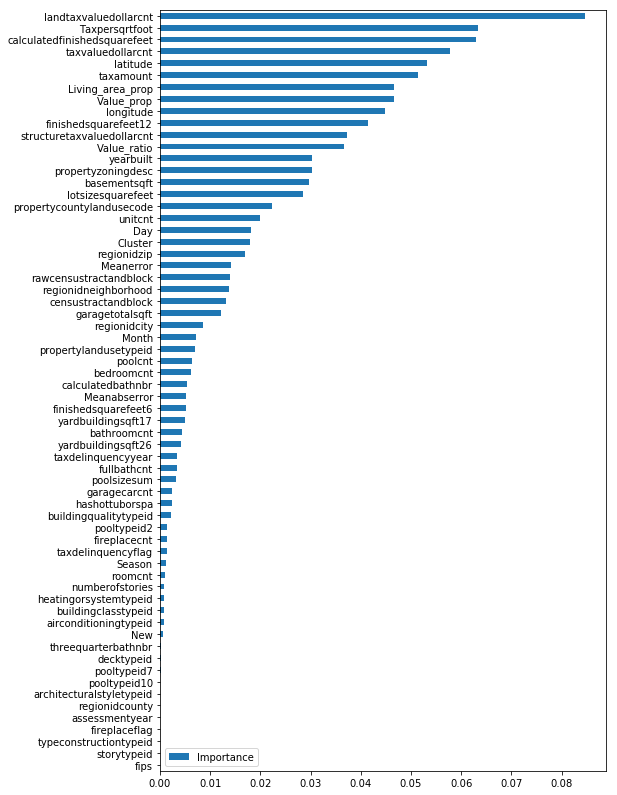

In [4]:
print(' Training GB ...')
X_train=X
y_train=y
n_estimators=800
clf = GradientBoostingRegressor(loss='lad',   n_estimators=n_estimators,  verbose=1)
clf.fit(X_train, y_train)
print('MAE train  {:.4f}'.format(np.mean(np.abs(y_train-clf.predict(X_train)) )))
gc.collect()

submit=False     # change to create the submission file
features=X_train.columns
if submit:
    print('predict and submit ...')
    X_test = (sample.merge(prop, on='ParcelId', how='left')).loc[:,features]
    
    if 'Season' in features: X_test['Season']=np.int8(1)
    if 'Day' in features: X_test['Day']=np.int8(15)

    for month in [10, 11, 12]:
        print('month ',month)
        if 'Month' in features: X_test['Month']=np.int8(month) 
        if 'Meanerror' in features: X_test['Meanerror']=np.float(month_err[month-1])
        if 'Meanabserror' in features: X_test['Meanabserror']=np.float(month_abs_err[month-1])
        sample['2016' + str(month)] = clf.predict(X_test)
        print(' MAE {}  {:.4f}'.format(month,np.mean(np.abs(sample['2016' + str(month)]-0) )))

    sample.to_csv('submission_GBR6445.csv', index = False, float_format = '%.5f')

FeatImp=pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['Importance'])
FeatImp=FeatImp.sort_values('Importance')
FeatImp.plot(kind='barh', figsize=(8,14))
plt.show()


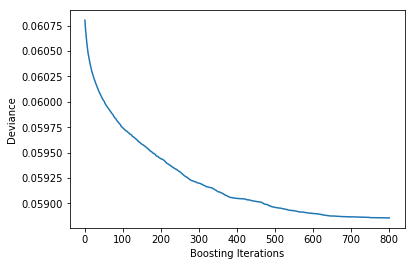

In [5]:
# Plot training deviance - 600 iteration seems enough
plt.plot(np.arange(n_estimators)+1, clf.train_score_)
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

feature impact ...
['finishedsquarefeet12' 'taxamount' 'taxvaluedollarcnt'
 'calculatedfinishedsquarefeet' 'landtaxvaluedollarcnt' 'longitude'
 'Taxpersqrtfoot' 'Value_ratio' 'structuretaxvaluedollarcnt' 'latitude']
latitude                       train 59.713 eval 60.351 
Value_prop                     train 59.702 eval 60.336 
Living_area_prop               train 59.459 eval 60.298 
lotsizesquarefeet              train 59.436 eval 60.307 
yearbuilt                      train 59.357 eval 60.260 
Cluster                        train 59.378 eval 60.241 
Day                            train 59.328 eval 60.273 
garagetotalsqft                train 59.243 eval 60.272 
propertyzoningdesc             train 59.338 eval 60.219 
regionidzip                    train 59.130 eval 60.230 
censustractandblock            train 59.289 eval 60.196 
Meanerror                      train 59.051 eval 60.092 
regionidcity                   train 58.902 eval 60.083 
basementsqft                   train 58.947

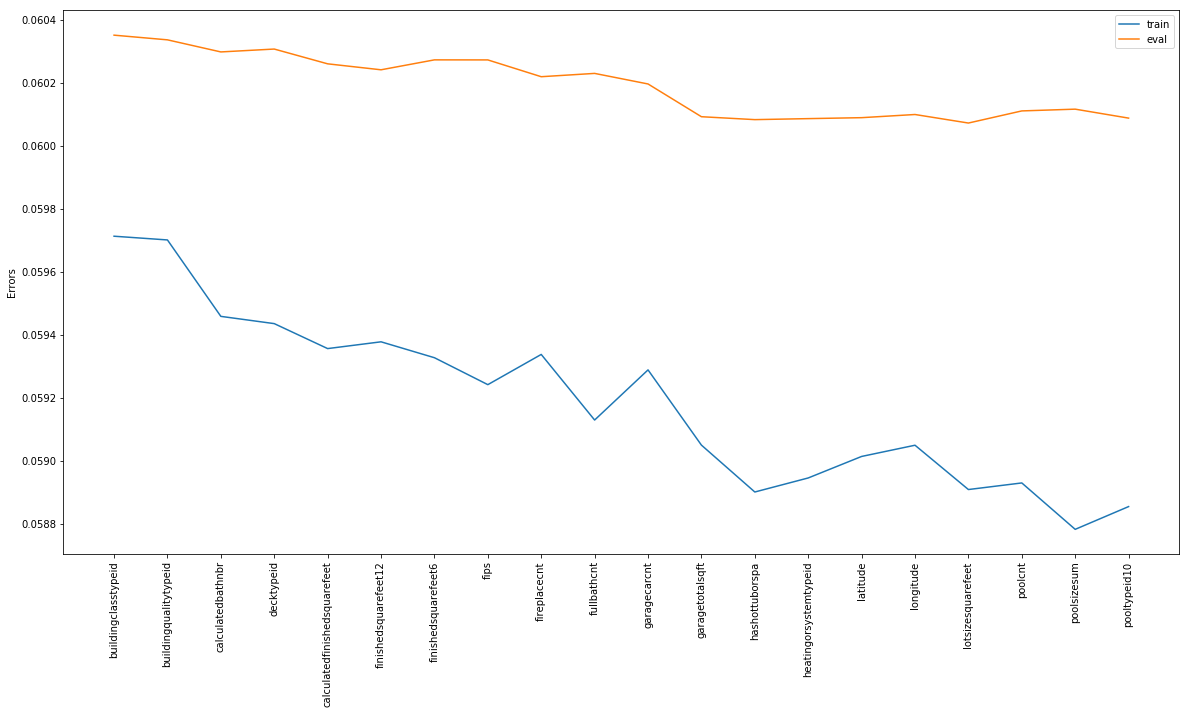

In [6]:
# starting with 10 most important features I gradually add more features to see their impact
# there are 64 features but after the first 30 the gain is quite small
print('feature impact ...')

X_train, X_eval, y_train, y_eval = train_test_split(X,y, test_size=0.5, random_state=1)
clf = GradientBoostingRegressor(loss='lad',   n_estimators=600,  verbose=0)
clf.fit(X_train, y_train)
FeatImp=pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['Importance'])
FeatImp=FeatImp.sort_values('Importance', ascending = False)
print( FeatImp.iloc[0:10].index.values )
Errors_train = []
Errors_eval = []

istart=10
iend=len(FeatImp)+1
iend = 30  # remove if time is no constraint and let run to the end (ie 64)
for i in range(istart,iend):
    X_train_temp = X_train[FeatImp.iloc[0:i].index.values]
    X_eval_temp = X_eval[FeatImp.iloc[0:i].index.values]
    clf.fit(X_train_temp, y_train)
    Err_eval = np.mean(np.abs(y_eval-clf.predict(X_eval_temp) ) )
    Err_train=np.mean(np.abs(y_train-clf.predict(X_train_temp) ) )
    print('{:<30} train {:.3f} eval {:.3f} '.format(FeatImp.index[i-1],1000*Err_train, 1000*Err_eval))
    Errors_train = Errors_train+[Err_train]
    Errors_eval = Errors_eval+[Err_eval]

plt.figure(figsize=(20,10))
plt.plot(range(istart,iend),Errors_train,label='train')
plt.plot(range(istart,iend),Errors_eval,label='eval')
plt.xticks(range(istart,iend), features[10:],rotation=90)
plt.ylabel('Errors')
plt.legend()
plt.show()   

In [7]:
print('Training lgbm ...')
features=list(X.columns)
cfeatures = list(X.select_dtypes(include = ['int64', 'int32', 'uint8', 'int8']).columns)

params = {'metric': 'mae', 'learning_rate' : 0.005, 'max_depth':10, 'max_bin':10,
         'feature_fraction': 0.95,'bagging_fraction':0.95,'bagging_freq':10,'min_data': 500}

# using eval or not (set CV to True or False)
CV=False
if CV:
    
    X_train, X_eval, y_train, y_eval = train_test_split(X,y, test_size=0.5, random_state=5)
    lgb_train = lgb.Dataset(X_train.values, y_train.values)
    lgb_eval = lgb.Dataset(X_eval.values, y_eval.values, reference = lgb_train)
    lgb_model = lgb.train(params, lgb_train, num_boost_round = 3000, valid_sets = lgb_eval, 
             feature_name=features, early_stopping_rounds=100, verbose_eval = 100)
    pred1 = lgb_model.predict(X_train.values, num_iteration = lgb_model.best_iteration)
    pred2 = lgb_model.predict(X_eval.values, num_iteration = lgb_model.best_iteration)
    print(' MAE train  {:.4f}'.format(np.mean(np.abs(y_train.values-pred1) )))
    print(' MAE eval   {:.4f}'.format(np.mean(np.abs(y_eval.values-pred2) )))
    del lgb_train,pred1,lgb_eval, pred2
    
else:

    X_train=X
    y_train=y
    lgb_train = lgb.Dataset(X_train.values, y_train.values)
    lgb_model = lgb.train(params, lgb_train, num_boost_round = 3000, feature_name=features)
    pred1 = lgb_model.predict(X_train.values, num_iteration = lgb_model.best_iteration)
    print(' MAE train  {:.4f}'.format(np.mean(np.abs(y_train.values-pred1) )))
    del lgb_train, pred1
    
    
lgb_model.save_model('model.txt')
#bst = lgb.Booster(model_file='model.txt')    
gc.collect()

Training lgbm ...
 MAE train  0.0590


35098

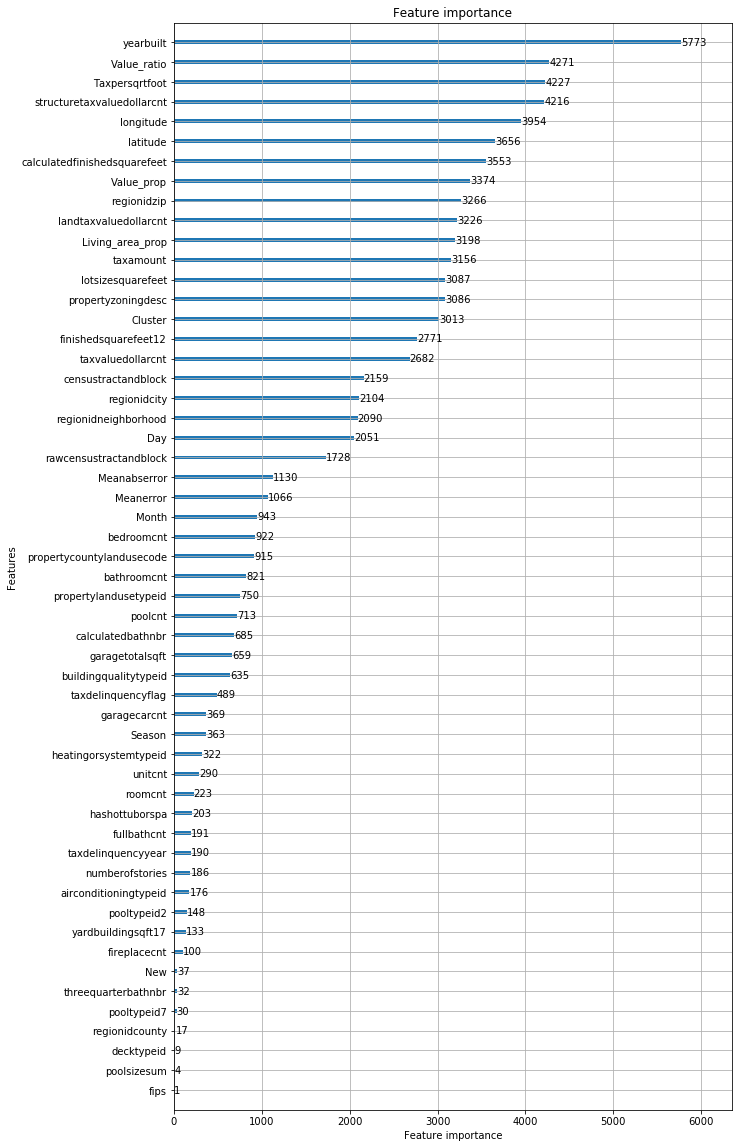

24611

In [8]:
#check feature importance
lgb.plot_importance(lgb_model,  figsize=(10,20))
plt.show()
gc.collect()

In [9]:
# I do not know if there is a more pythonic way to get the lgbm feature importances but the best I 
# could do is by parsing the model file
ind=[]
data=[]
with open('model.txt') as f: FI = list(f)[-100:-2]
FI=FI[FI.index('feature importances:\n') +1:]    
for i in range(len(FI)): 
    FI[i]=FI[i][:-1]
    ind=ind+[FI[i].split('=')[0]]
    data=data+[int(FI[i].split('=')[1])]
FeatImp=pd.DataFrame(data, index=ind, columns=['Importance'])
del f,ind,data
FeatImp.head()

,Importance
yearbuilt,5773
Value_ratio,4271
Taxpersqrtfoot,4227
structuretaxvaluedollarcnt,4216
longitude,3954


Obviously the feature importances depend on the choice of the parameters but still the first attempt to compare gbr and lgbm leads to quite large differences and so it makes sense to combine the different methods. Finally, let us compare with xgb. 

In [10]:
print('training xgboost ...')
X_train=X
y_train=y
y_mean = np.mean(y_train)
xgb_params = {'eta': 0.037, 'max_depth': 5, 'subsample': 0.80,  'eval_metric': 'mae', 
              'lambda': 0.8,   'alpha': 0.4, 'base_score': y_mean, 'silent': 1 }
dtrain = xgb.DMatrix(X_train, y_train)
model = xgb.train(xgb_params, dtrain, num_boost_round=250)
pred1 = model.predict(dtrain)
print(' xgb MAE train  {:.4f}'.format(np.mean(np.abs(y_train.values-pred1) )))
del dtrain, pred1
gc.collect()

training xgboost ...
 xgb MAE train  0.0590


48

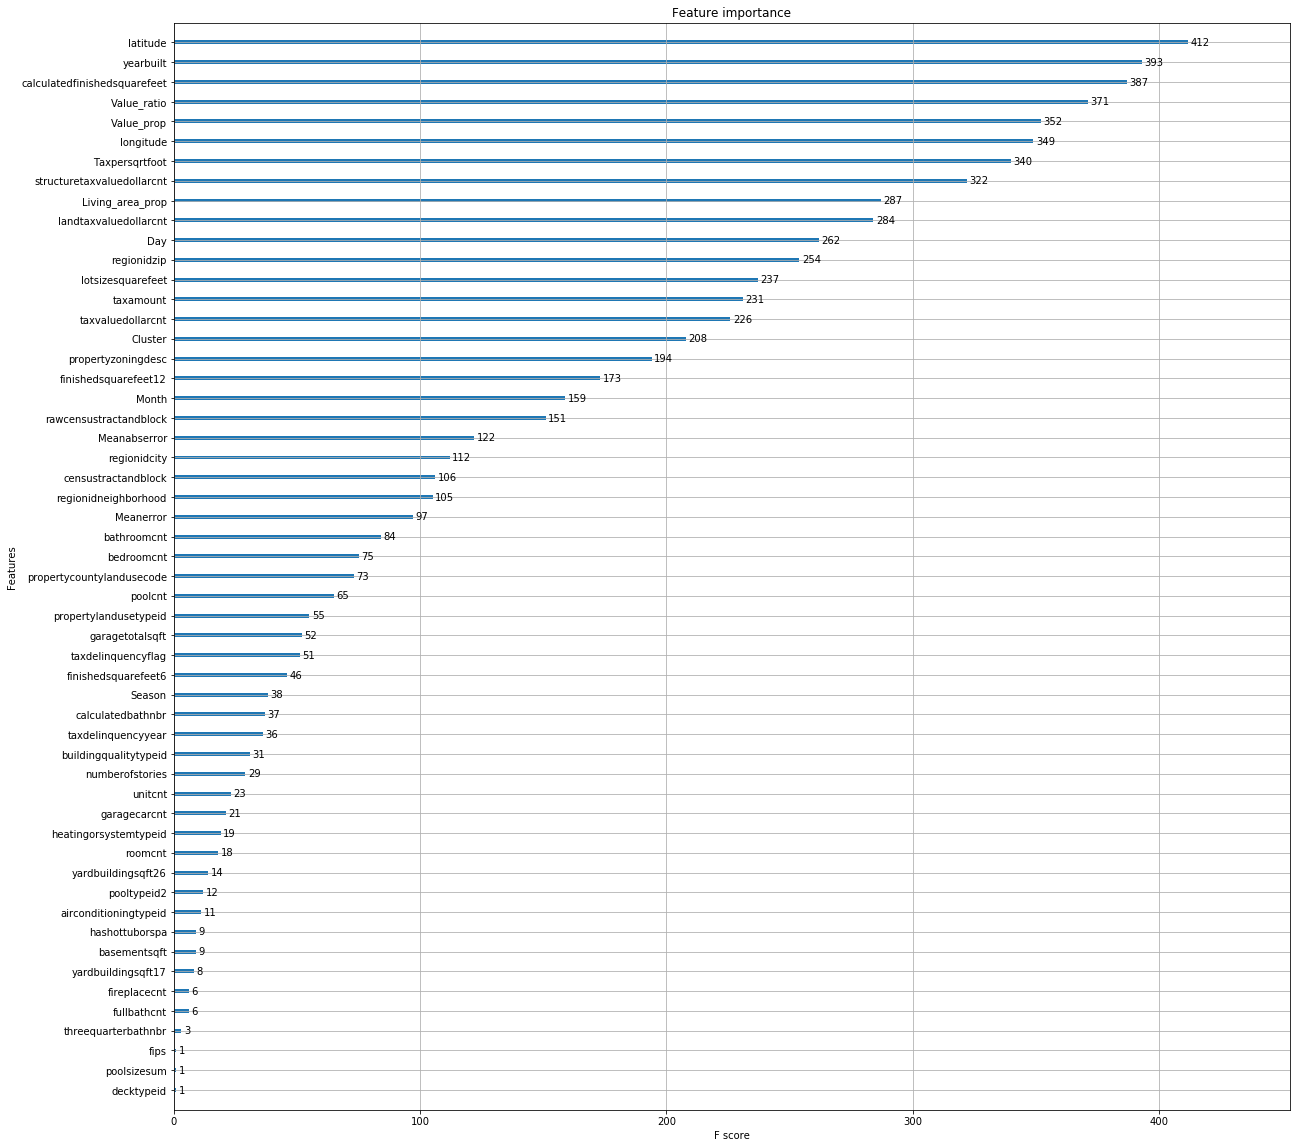

1710

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(model, ax=ax)
plt.show()
gc.collect()

Work in progress ...
